In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
import zipfile

with zipfile.ZipFile('rps.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = 'rps'

train_dir = 'rps_train'
validation_dir = 'rps_validation'
test_dir = 'rps_test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(source_dir):
    source_class_dir = os.path.join(source_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    validation_class_dir = os.path.join(validation_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(validation_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    files = os.listdir(source_class_dir)
    train_files, test_files = train_test_split(files, test_size=0.30, random_state=42)
    validation_files, test_files = train_test_split(test_files, test_size=0.05, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(source_class_dir, file), os.path.join(train_class_dir, file))
    for file in validation_files:
        shutil.copy(os.path.join(source_class_dir, file), os.path.join(validation_class_dir, file))
    for file in test_files:
        shutil.copy(os.path.join(source_class_dir, file), os.path.join(test_class_dir, file))

In [4]:
test_dir = r'C:\Users\Kouma\rps_test'
train_dir = r'C:\Users\Kouma\rps_train'
validation_dir_dir = r'C:\Users\Kouma\rps_validation'

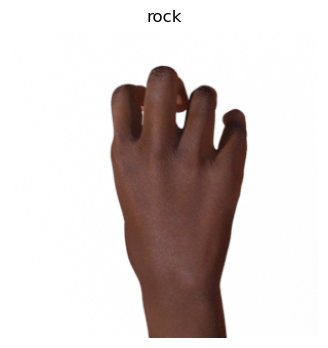

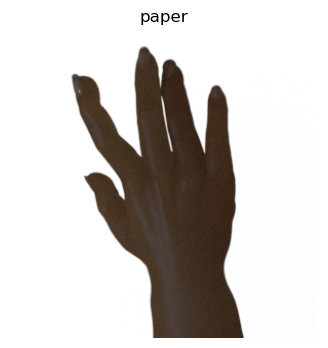

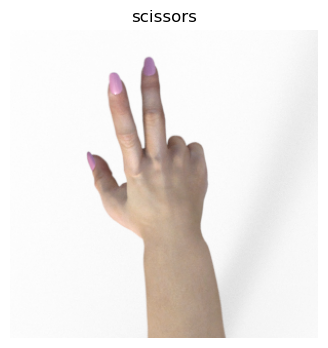

In [5]:
#tampilkan gambar
def plot_sample_images(directory):
    classes = ['rock', 'paper', 'scissors']
    for c in classes:
        img_path = os.path.join(directory, c)
        img = random.choice(os.listdir(img_path))
        img = os.path.join(img_path, img)
        img = plt.imread(img)
        plt.figure(figsize=(4, 4))
        plt.title(c)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

plot_sample_images(train_dir)


In [6]:
#Pre-processing dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 1764 images belonging to 3 classes.
Found 717 images belonging to 3 classes.


In [7]:
#Membuat model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

input_shape = (128, 128, 3)
input_tensor = Input(shape=input_shape)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


In [10]:
transfer_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               10486272  
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 12,745,795
Trainable params: 10,487,811
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
history = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
)

# Evaluasi model
test_loss, test_acc = transfer_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
55/55 [==============================] - 43s 724ms/step - loss: 1.2811 - accuracy: 0.9070 - val_loss: 0.0842 - val_accuracy: 0.9901
Epoch 2/10
55/55 [==============================] - 29s 521ms/step - loss: 0.1564 - accuracy: 0.9769 - val_loss: 0.1671 - val_accuracy: 0.9872
Epoch 3/10
55/55 [==============================] - 36s 651ms/step - loss: 0.0717 - accuracy: 0.9873 - val_loss: 0.0981 - val_accuracy: 0.9901
Epoch 4/10
55/55 [==============================] - 33s 594ms/step - loss: 0.1104 - accuracy: 0.9804 - val_loss: 0.1128 - val_accuracy: 0.9901
Epoch 5/10
55/55 [==============================] - 30s 539ms/step - loss: 0.0925 - accuracy: 0.9838 - val_loss: 0.0970 - val_accuracy: 0.9844
Epoch 6/10
55/55 [==============================] - 31s 568ms/step - loss: 0.0544 - accuracy: 0.9873 - val_loss: 0.1695 - val_accuracy: 0.9830
Epoch 7/10
55/55 [==============================] - 35s 628ms/step - loss: 0.1677 - accuracy: 0.9740 - val_loss: 0.0031 - val_accuracy: 0.9986

NameError: name 'test_generator' is not defined

In [15]:
# Parameter untuk ImageDataGenerator
batch_size = 10
img_size = (128, 128)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 378 images belonging to 3 classes.


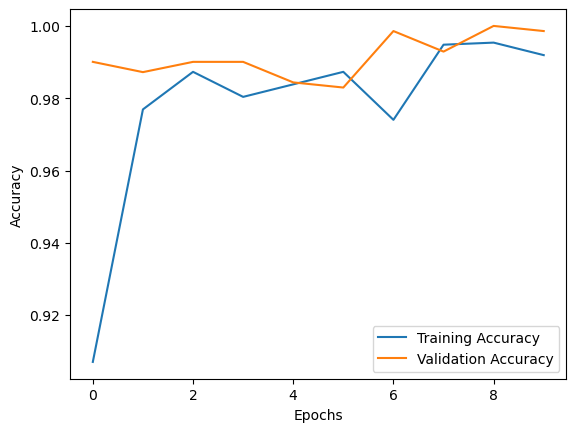

In [16]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:

# Classification Report
test_generator.reset()
Y_pred = transfer_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=class_labels))

38/38 [==============================] - 5s 87ms/step
              precision    recall  f1-score   support

       paper       1.00      0.99      1.00       126
        rock       1.00      1.00      1.00       126
    scissors       0.99      1.00      1.00       126

    accuracy                           1.00       378
   macro avg       1.00      1.00      1.00       378
weighted avg       1.00      1.00      1.00       378



In [18]:
# Evaluasi model
test_loss, test_acc = transfer_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

38/38 [==============================] - 3s 82ms/step - loss: 0.0024 - accuracy: 0.9974
Test accuracy: 0.9973545074462891


1/1 [==============================] - 1s 791ms/step


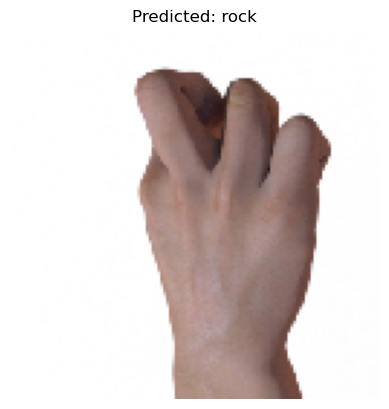

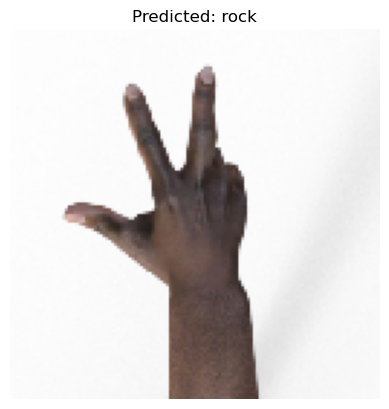

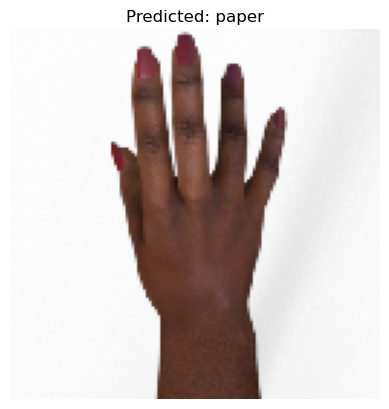

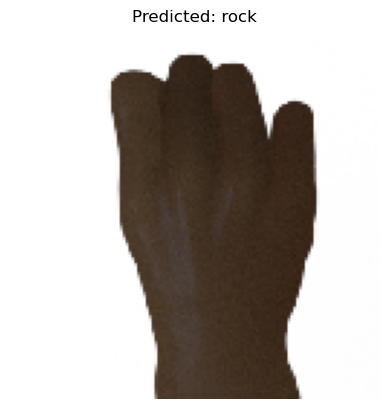

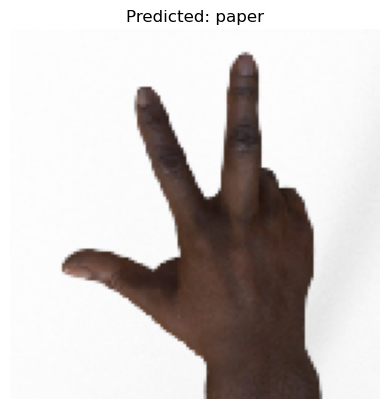

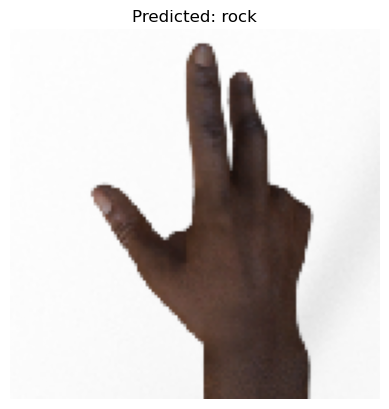

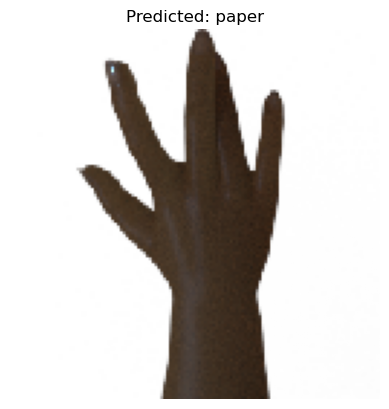

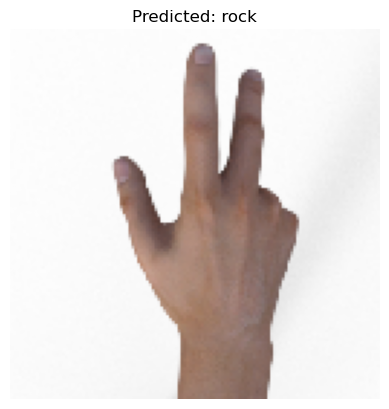

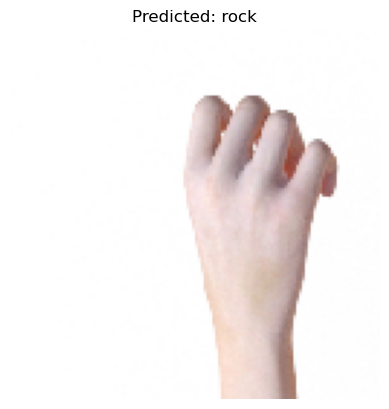

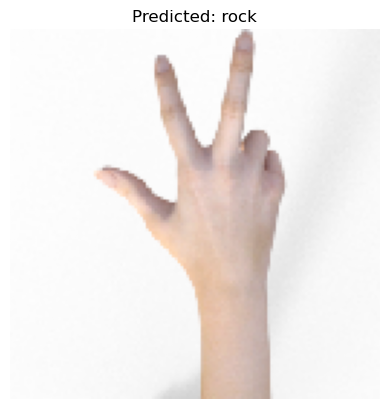

In [20]:
from random import sample
from tensorflow.keras.preprocessing.image import load_img, img_to_array


random_indexes = sample(range(len(test_generator.filenames)), 10)
selected_images = []
for idx in random_indexes:
    img_path = f"{test_dir}/{test_generator.filenames[idx]}"
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    selected_images.append(img_array)

selected_images = np.array(selected_images)

predictions = transfer_model.predict(selected_images)

predicted_classes = np.argmax(predictions, axis=1)

class_labels = {0: 'paper', 1: 'rock', 2: 'scissors'}

for i in range(10):
    plt.imshow(selected_images[i] / 255.0)
    plt.title(f"Predicted: {class_labels[predicted_classes[i]]}")
    plt.axis('off')
    plt.show()

In [23]:
transfer_model.save('model.h5')
